***Note: This notebook is dedicated to demonstrate the process of data exploratory, preprocessing, transformation and feature engineering. The modeling parts are in handled in seperate notebook files.**

# 1. Loading Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import seaborn as sns

In [ ]:
train_image_dir = '../input/UBC-OCEAN/train_images'
test_image_dir = '../input/UBC-OCEAN/test_images'
train_thumbnails_folder_path = '../input/UBC-OCEAN/train_thumbnails'
test_thumbnails_folder_path = '../input/UBC-OCEAN/test_thumbnails'

**1. Loading training label file**

In [ ]:
train_data = pd.read_csv('../input/UBC-OCEAN/train.csv')
train_data

image_id label  image_width  image_height  is_tma
0           4  HGSC        23785         20008   False
1          66  LGSC        48871         48195   False
2          91  HGSC         3388          3388    True
3         281  LGSC        42309         15545   False
4         286    EC        37204         30020   False
..        ...   ...          ...           ...     ...
533     65022  LGSC        53355         46675   False
534     65094    MC        55042         45080   False
535     65300  HGSC        75860         27503   False
536     65371  HGSC        42551         41800   False
537     65533  HGSC        45190         33980   False

[538 rows x 5 columns]

Since the 'train_thumbnails' folder contains smaller-sized images, we can use them for model processing. However, not all images in the training set are located in 'train_thumbnails,' so we need to identify the missing ones and process them accordingly.

In [ ]:
train_files = [filename.split('.')[0] for filename in os.listdir(train_image_dir)]
thumbnails_files = [filename.replace('_thumbnail', '').split('.')[0] for filename in os.listdir(train_thumbnails_folder_path)]

In [ ]:
train_set = set(train_files)
thumbnails_set = set(thumbnails_files)


missing_image_ids = train_set - thumbnails_set
missing_image_ids_list = list(missing_image_ids)

print("Image IDs in train_files but not in thumbnails_files:")
print(missing_image_ids_list)

Image IDs in train_files but not in thumbnails_files:
['37385', '35565', '57696', '47035', '36783', '31594', '41586', '17637', '48734', '29084', '50932', '4134', '8280', '42857', '40864', '91', '36302', '9200', '36583', '21020', '41368', '13568', '53655', '61797', '44603']


In [ ]:
missing_image_ids_list = [int(image_id) for image_id in missing_image_ids_list]
filtered_train_data = train_data[train_data['image_id'].isin(missing_image_ids_list)]

filtered_train_data

image_id label  image_width  image_height  is_tma
2          91  HGSC         3388          3388    True
37       4134    MC         2964          2964    True
76       8280  HGSC         2964          2964    True
83       9200    MC         3388          3388    True
112     13568  LGSC         2964          2964    True
149     17637  HGSC         2964          2964    True
176     21020    MC         3388          3388    True
236     29084  LGSC         3388          3388    True
263     31594    EC         3388          3388    True
288     35565    MC         2964          2964    True
299     36302    CC         3388          3388    True
302     36583  LGSC         3388          3388    True
305     36783    MC         2964          2964    True
309     37385  LGSC         3388          3388    True
350     40864  LGSC         2964          2964    True
354     41368    EC         3388          3388    True
355     41586    CC         2964          2964    True
361     42857    CC         2964          2964    True
375     44603    CC         3388          3388    True
399     47035    EC         2964          2964    True
409     48734    EC         3388          3388    True
423     50932  HGSC         2964          2964    True
452     53655    EC         3388          3388    True
484     57696    CC         3388          3388    True
510     61797  HGSC         3388          3388    True

Since all the missing images in thumbnails are TMA images that are small sized, we can use them from the train_images folder instead.

In [ ]:
# creating full path column for each image in the train_data dataframe

train_data['full_path'] = ''
for index, row in train_data.iterrows():
    image_id = row['image_id']
    if image_id in missing_image_ids_list:
        train_data.at[index, 'full_path'] = os.path.join(train_image_dir, str(image_id) + '.png')
    else:
        train_data.at[index, 'full_path'] = os.path.join(train_thumbnails_folder_path, str(image_id) + '_thumbnail.png')

train_data

image_id label  image_width  image_height  is_tma  \
0           4  HGSC        23785         20008   False   
1          66  LGSC        48871         48195   False   
2          91  HGSC         3388          3388    True   
3         281  LGSC        42309         15545   False   
4         286    EC        37204         30020   False   
..        ...   ...          ...           ...     ...   
533     65022  LGSC        53355         46675   False   
534     65094    MC        55042         45080   False   
535     65300  HGSC        75860         27503   False   
536     65371  HGSC        42551         41800   False   
537     65533  HGSC        45190         33980   False   

                                             full_path  
0    ../input/UBC-OCEAN/train_thumbnails/4_thumbnai...  
1    ../input/UBC-OCEAN/train_thumbnails/66_thumbna...  
2               ../input/UBC-OCEAN/train_images/91.png  
3    ../input/UBC-OCEAN/train_thumbnails/281_thumbn...  
4    ../input/UBC-OCEAN/train_thumbnails/286_thumbn...  
..                                                 ...  
533  ../input/UBC-OCEAN/train_thumbnails/65022_thum...  
534  ../input/UBC-OCEAN/train_thumbnails/65094_thum...  
535  ../input/UBC-OCEAN/train_thumbnails/65300_thum...  
536  ../input/UBC-OCEAN/train_thumbnails/65371_thum...  
537  ../input/UBC-OCEAN/train_thumbnails/65533_thum...  

[538 rows x 6 columns]

# 2. Exploratory Data Analysis (EDA)

**1. Label and Image Type Distribution**

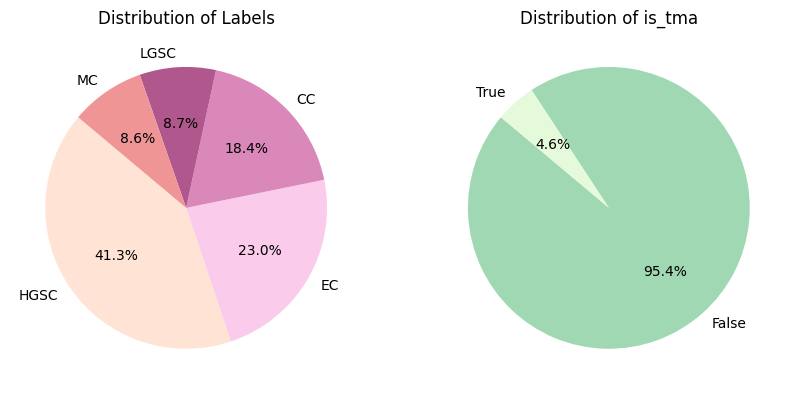

In [ ]:
import matplotlib.pyplot as plt
colors = ['#FFE4D6', '#FACBEA', '#D988B9', '#B0578D', '#EF9595']
# Extracting label distribution
labels = train_data['label'].value_counts().index
sizes = train_data['label'].value_counts().values

# Extracting is_tma distribution
is_tma_counts = train_data['is_tma'].value_counts()

# Plotting side-by-side pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plotting the pie chart for label distribution
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax1.set_title('Distribution of Labels')

# Plotting the pie chart for is_tma distribution
ax2.pie(is_tma_counts, labels=is_tma_counts.index, autopct='%1.1f%%', startangle=140, colors=['#A0D8B3', '#E5F9DB'])
ax2.set_title('Distribution of is_tma')

plt.show()



**2. Statistics of images for each label**

In [ ]:
import pandas as pd


columns_to_exclude = ['image_id']
styled_summaries = {}

for label in train_data['label'].unique():
    filtered_data = train_data[train_data['label'] == label].drop(columns=columns_to_exclude)
    sta_summary = filtered_data.describe(include=['float64', 'int64', 'float', 'int']).round(2)
    styled_summary = sta_summary.T.style.background_gradient(cmap='magma', low=0.2, high=0.1).set_caption(f'<h2 style="text-align:center;font-size:15px">{label} Summary Table')
    styled_summaries[label] = styled_summary

# Display the styled summaries for each label
for label, styled_summary in styled_summaries.items():
    display(styled_summary)


**3. Boxplot of image_width and image_height for each label**

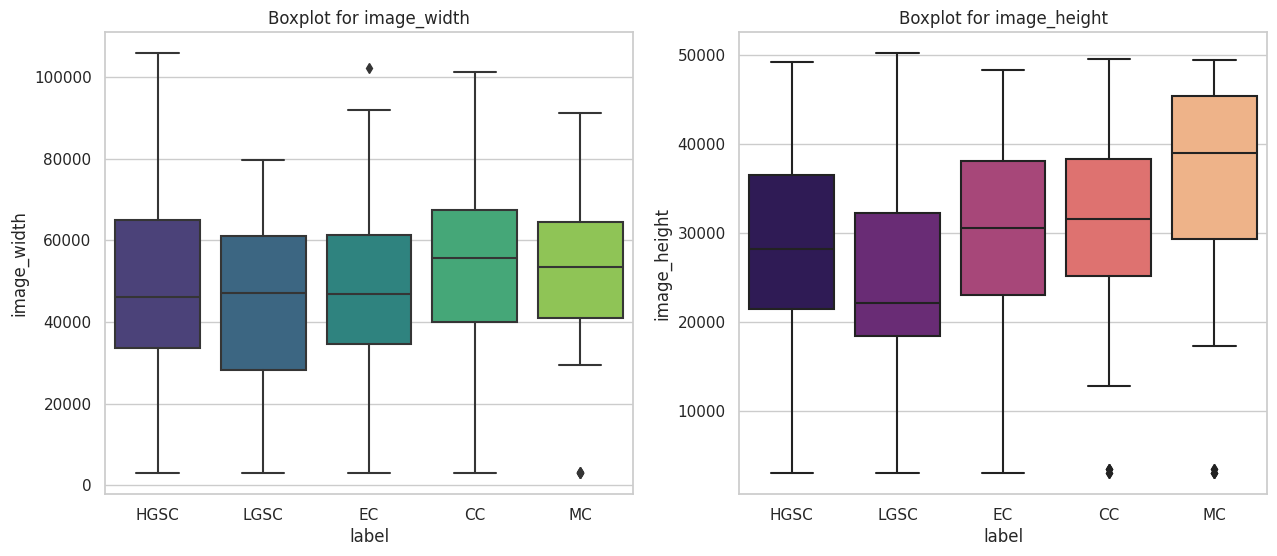

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create subplots for 'image_width' and 'image_height'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Boxplot for image_width
sns.boxplot(x='label', y='image_width', data=train_data, palette='viridis', ax=axes[0])
axes[0].set_title('Boxplot for image_width')

# Boxplot for image_height
sns.boxplot(x='label', y='image_height', data=train_data, palette='magma', ax=axes[1])
axes[1].set_title('Boxplot for image_height')

plt.show()



**3. Thumnails and train image distribution**

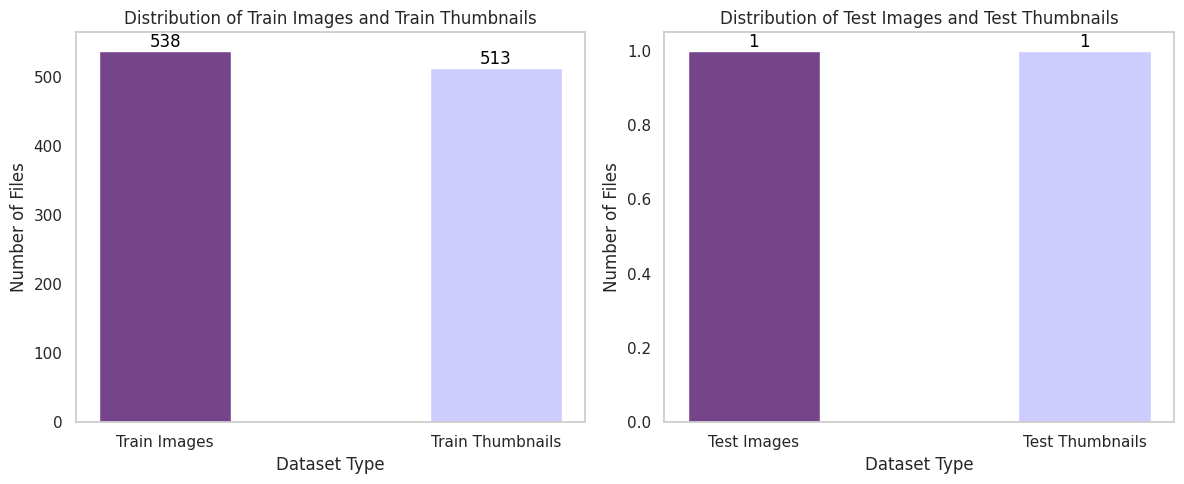

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_distribution(image_dir, thumbnail_dir, data_type, ax):
    image_count = len(os.listdir(image_dir))
    thumbnail_count = len(os.listdir(thumbnail_dir))

    labels = ['Images', 'Thumbnails']
    counts = [image_count, thumbnail_count]

    bars = ax.bar([data_type + ' ' + label for label in labels], counts, color=['#76448A', '#CCCCFF'], width=0.4)  # Adjusted bar width

    for bar, count in zip(bars, counts):
        yval = bar.get_height()
        text_ypos = max(yval, 0.5)
        ax.text(bar.get_x() + bar.get_width()/2, text_ypos, round(count, 2), ha='center', va='bottom', color='black')

    ax.grid(False)
    ax.set_title(f'Distribution of {data_type} Images and {data_type} Thumbnails')
    ax.set_xlabel('Dataset Type')
    ax.set_ylabel('Number of Files')


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_distribution(train_image_dir, train_thumbnails_folder_path, 'Train', axes[0])
plot_distribution(test_image_dir, test_thumbnails_folder_path, 'Test', axes[1])

plt.tight_layout()
plt.show()


**4. Randomly plot images from training set**

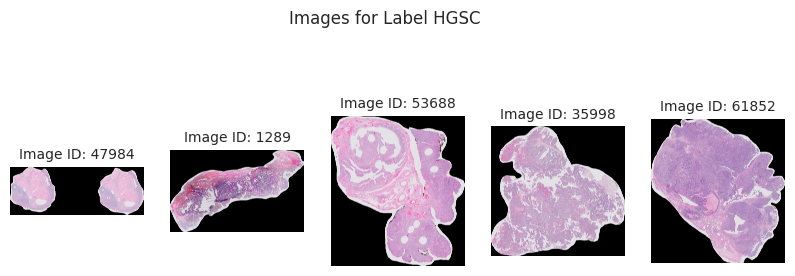

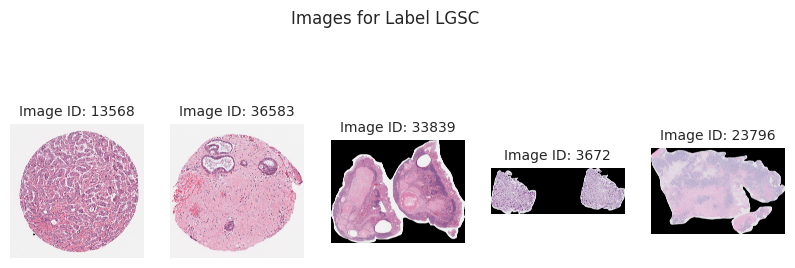

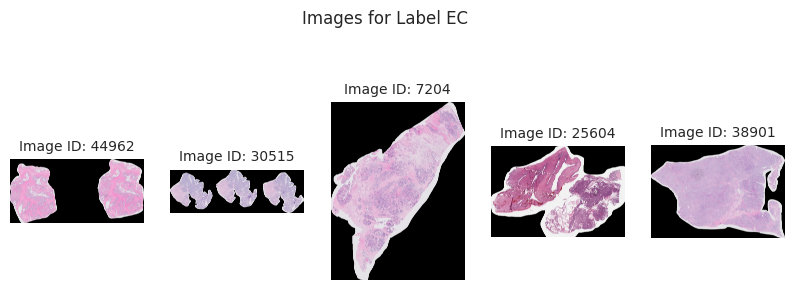

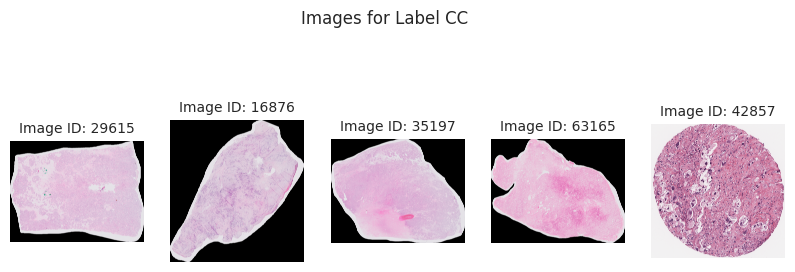

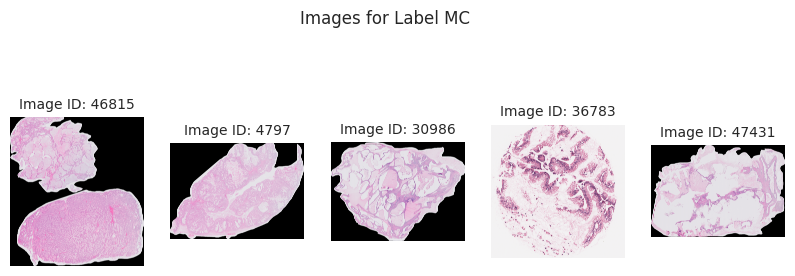

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

label_column = 'label'
path_column = 'full_path'
image_id_column = 'image_id'

unique_labels = train_data[label_column].unique()

images_per_label = 5

# Randomly select and plot 5 images for each label
for label in unique_labels:
    label_data = train_data[train_data[label_column] == label]
    sample_images = label_data.sample(min(images_per_label, len(label_data)))

    plt.figure(figsize=(10, 3))
    plt.suptitle(f'Images for Label {label}', y=1.1, fontsize=12)  # Adjusted font size

    for i, (_, row) in enumerate(sample_images.iterrows()):
        image_path = row[path_column]
        image = Image.open(image_path)

        plt.subplot(1, images_per_label, i + 1)
        plt.imshow(image)
        plt.title(f'Image ID: {row[image_id_column]}', fontsize=10)
        plt.axis('off')

    plt.show()



**5. Plot images from test set**

In [ ]:
test_data = pd.read_csv('../input/UBC-OCEAN/test.csv')
test_data

image_id  image_width  image_height
0        41        28469         16987

In [ ]:
test_thumbnails_folder_path = '../input/UBC-OCEAN/test_thumbnails'
test_data['full_path'] = test_data['image_id'].apply(lambda x: os.path.join(test_thumbnails_folder_path, f"{x}_thumbnail.png"))

test_data

image_id  image_width  image_height  \
0        41        28469         16987   

                                           full_path  
0  ../input/UBC-OCEAN/test_thumbnails/41_thumbnai...

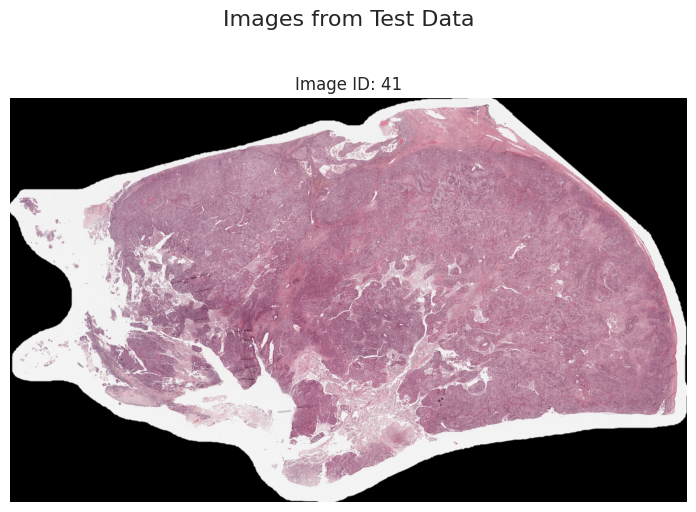

In [ ]:
import os
from PIL import Image

image_id_column = 'image_id'
width_column = 'image_width'
height_column = 'image_height'
path_column = 'full_path'

num_images_to_plot = len(test_data)

plt.figure(figsize=(10, 5 * num_images_to_plot))
plt.suptitle(f'Images from Test Data', y=1.02, fontsize=16)

for i, (_, row) in enumerate(test_data.iterrows()):
    image_path = row[path_column]
    image = Image.open(image_path)

    plt.subplot(num_images_to_plot, 1, i + 1)
    plt.imshow(image)
    plt.title(f'Image ID: {row[image_id_column]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# 3. Data Preprocessing

Convert text labels to numerical labels

In [ ]:
label_mapping = {'CC': 0, 'EC': 1, 'HGSC': 2, 'LGSC': 3, 'MC': 4}
train_data['numerical_label'] = train_data['label'].map(label_mapping)

In [ ]:
label_counts = train_data['label'].value_counts()
label_counts

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

As indicated above, the classes are very imbalanced. Therefore, we increase the number of images for each class by upsampling (The number increase can vary by models)

In [ ]:
from sklearn.utils import resample

# Define the target number of samples for each class
target_samples = 222

# Resample each class to have the target number of samples
resampled_data = []
for label in train_data['numerical_label'].unique():
    class_data = train_data[train_data['numerical_label'] == label]
    resampled_class = resample(class_data, replace=True, n_samples=target_samples, random_state=42)
    resampled_data.append(resampled_class)

balanced_train_data = pd.concat(resampled_data)

# 4. Data Transformation

**1. Data Normalization and convert image data to numpy array**

In [ ]:
# Resize images to 256x256
image_size = (256, 256)

x_balanced = np.empty(shape=(len(balanced_train_data), *image_size, 3), dtype=np.uint8)
y_balanced = np.empty(shape=len(balanced_train_data), dtype=np.uint8)

for index, full_path in enumerate(balanced_train_data['full_path']):
    image_array = Image.open(full_path).resize(image_size).convert('RGB')
    x_balanced[index] = np.array(image_array)
    y_balanced[index] = balanced_train_data.iloc[index]['numerical_label']

print(x_balanced.shape)
print(y_balanced.shape)

(1110, 256, 256, 3)
(1110,)


In [ ]:
print(x_balanced)

[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0

In [ ]:
print(y_balanced)

[2 2 2 ... 4 4 4]


**2. Set target to one-hot labels for classification problem**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
y_targets_balanced = y_balanced.reshape(len(y_balanced), -1)
enc = OneHotEncoder()
enc.fit(y_targets_balanced)
y_balanced = enc.transform(y_targets_balanced).toarray()
print(y_balanced.shape)

(1110, 5)


In [ ]:
print(y_balanced)

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


**3. Data Augumentation for training data to increase the variation of images**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the balanced data into 80% training and 20% validation
x_train, x_val, y_train, y_val  = train_test_split(
    x_balanced, y_balanced, test_size=0.2, random_state=1, stratify=y_balanced
)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((888, 256, 256, 3), (222, 256, 256, 3), (888, 5), (222, 5))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

**4. Image after agumentation**

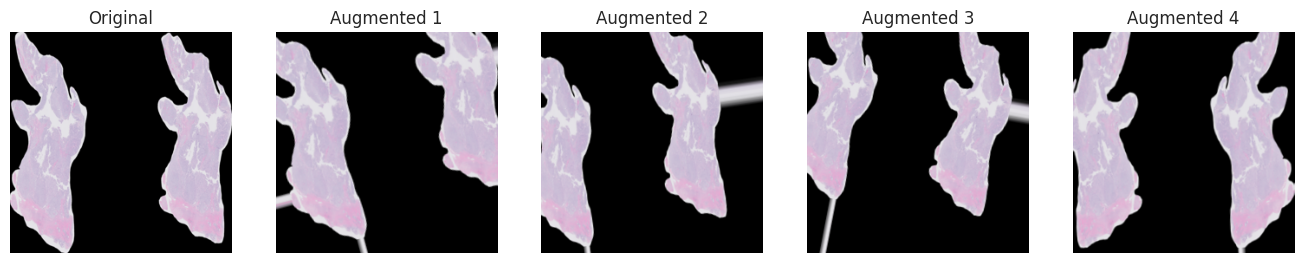

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose a sample image from x_train
sample_image = x_train[2]
sample_image = np.expand_dims(sample_image, axis=0)

# Generate augmented images
augmented_images = datagen.flow(sample_image, batch_size=5)


plt.figure(figsize=(20, 10))

# Plot the original image
plt.subplot(1, 6, 1)
plt.imshow(sample_image[0].astype('uint8'))
plt.axis('off')
plt.title('Original')

# Plot the augmented images
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_image[0].astype('uint8'))
    plt.axis('off')
    plt.title(f'Augmented {i + 1}')

    if i == 3:
        break  # Display only 4 augmented images

plt.show()


# 5. Feature Engineering

**Examine one sample image from each label**

In [ ]:
feature_extraction_df = train_data.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)
feature_extraction_df = feature_extraction_df[['image_id', 'label', 'full_path']]

feature_extraction_df

image_id label                                          full_path
0     47960    CC  ../input/UBC-OCEAN/train_thumbnails/47960_thum...
1     46444    EC  ../input/UBC-OCEAN/train_thumbnails/46444_thum...
2     47911  HGSC  ../input/UBC-OCEAN/train_thumbnails/47911_thum...
3     13387  LGSC  ../input/UBC-OCEAN/train_thumbnails/13387_thum...
4      6582    MC  ../input/UBC-OCEAN/train_thumbnails/6582_thumb...

**1: Color Histograms**

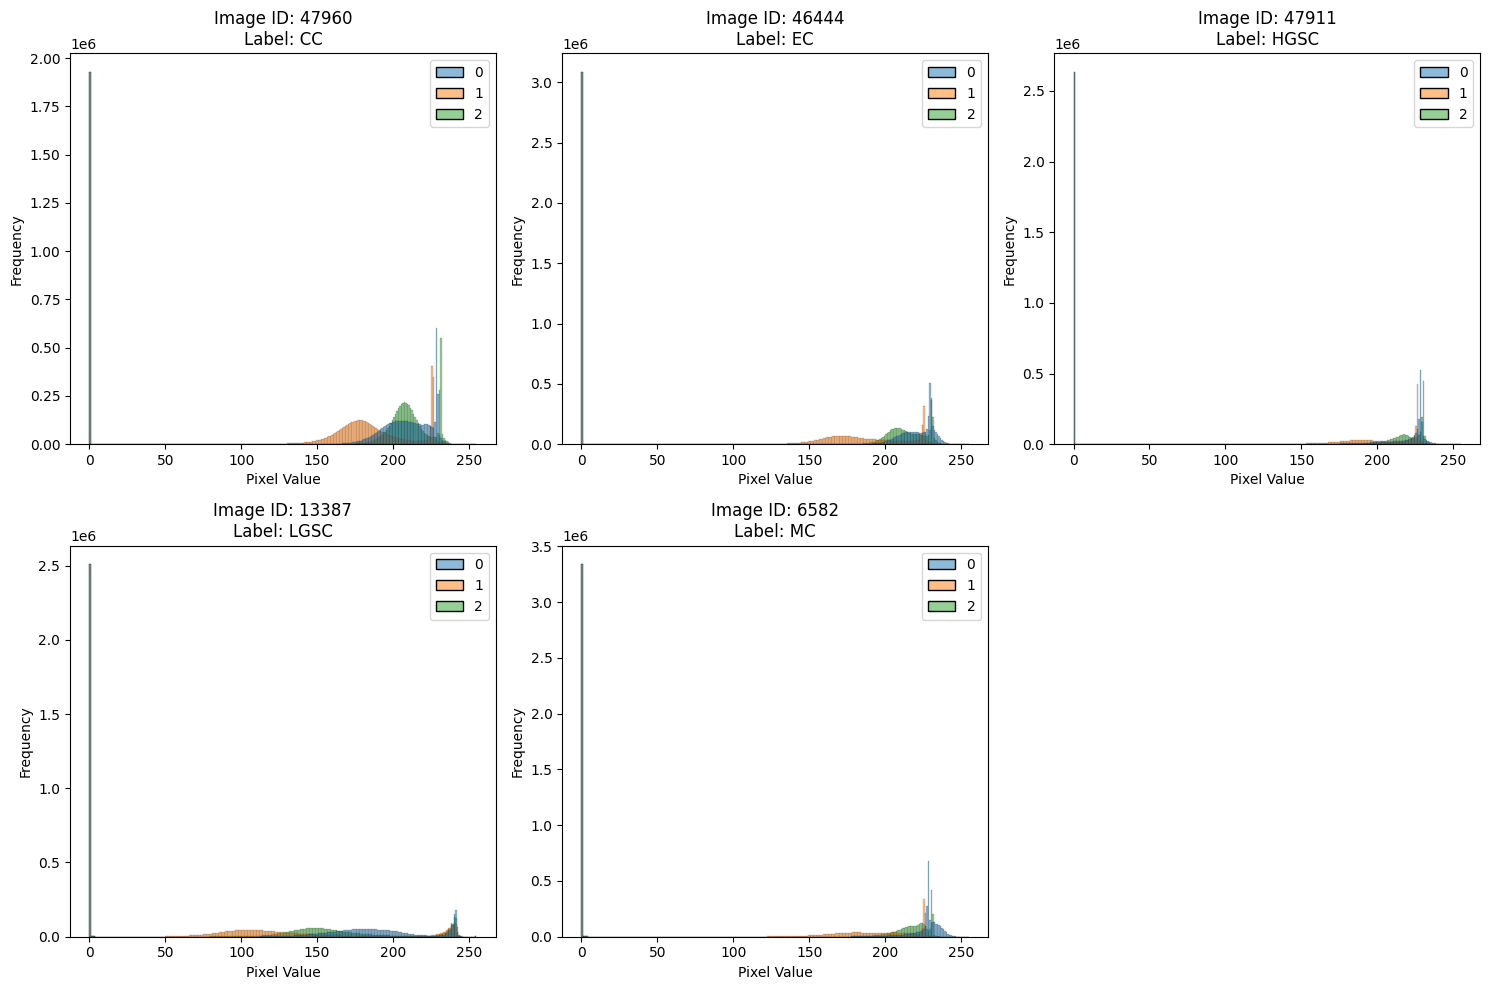

In [ ]:
import math

def create_color_histogram(image_path, image_id, label):
    image = Image.open(image_path)
    np_image = np.array(image)
    flattened_array = np_image.reshape((-1, 3))

    # Plot the color histogram using seaborn
    sns.histplot(flattened_array, bins=256, kde=False)
    plt.title(f'Image ID: {image_id}\nLabel: {label}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')


num_images = len(feature_extraction_df)
num_rows = math.ceil(num_images / 3)


plt.figure(figsize=(15, 5 * num_rows))


for idx, row in feature_extraction_df.iterrows():
    subplot_position = (num_rows, 3, idx % (3 * num_rows) + 1)

    plt.subplot(*subplot_position)
    create_color_histogram(row['full_path'], row['image_id'], row['label'])

plt.tight_layout()
plt.show()


**2: Grayscale Features**

Flattened Array for Image ID 0 and Label CC:
[0 0 0 ... 0 0 0]



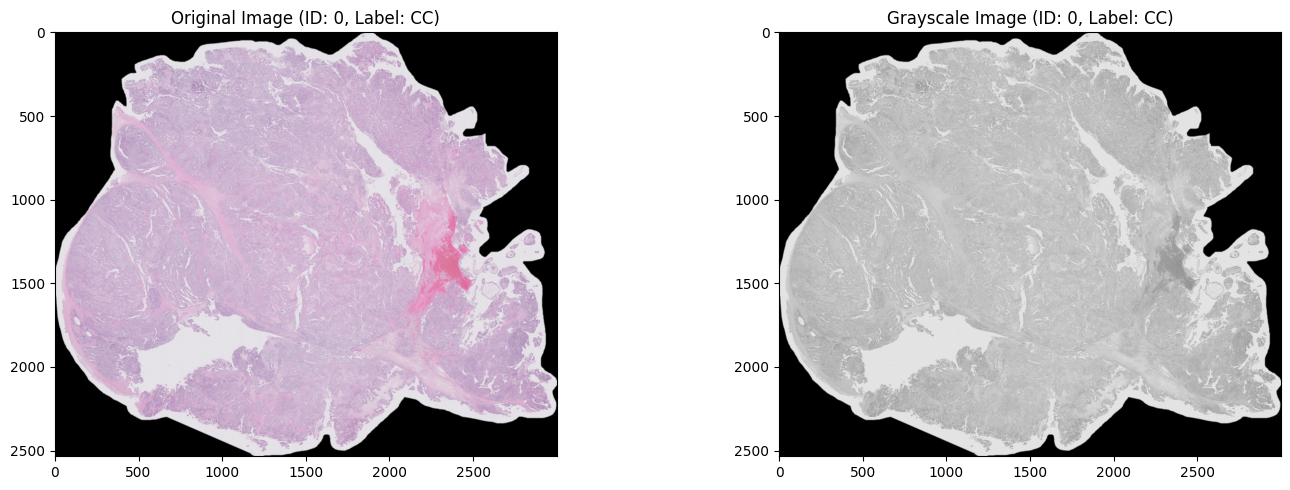

Flattened Array for Image ID 1 and Label EC:
[0 0 0 ... 0 0 0]



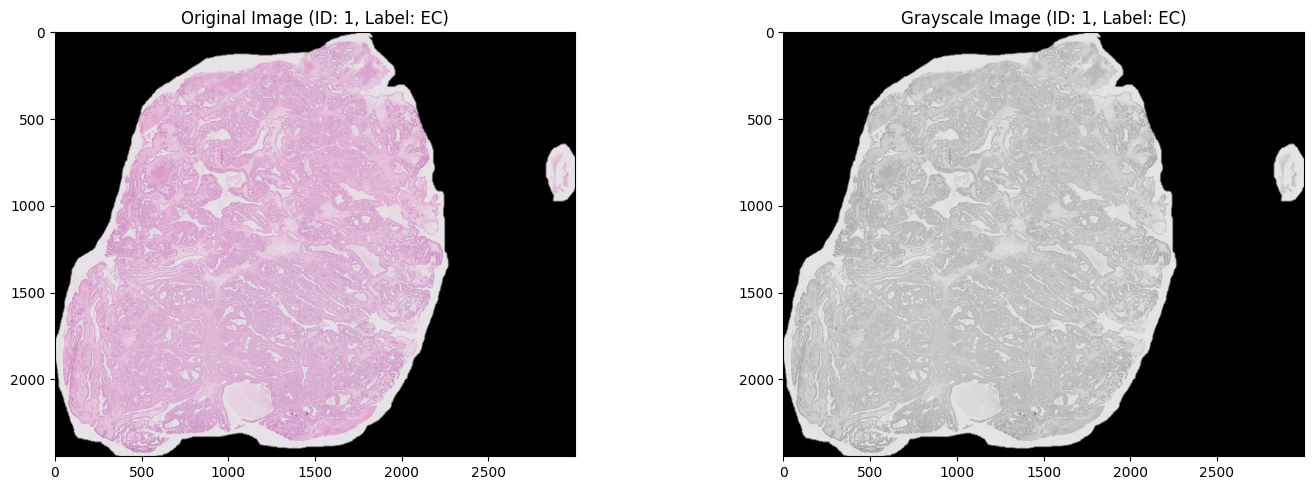

Flattened Array for Image ID 2 and Label HGSC:
[0 0 0 ... 0 0 0]



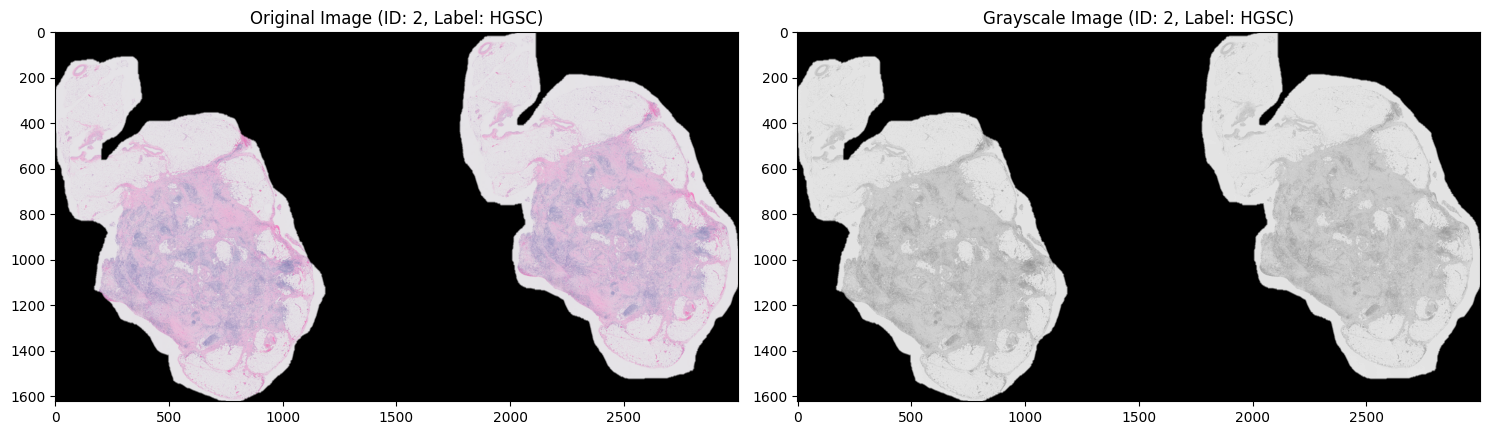

Flattened Array for Image ID 3 and Label LGSC:
[0 0 0 ... 0 0 0]



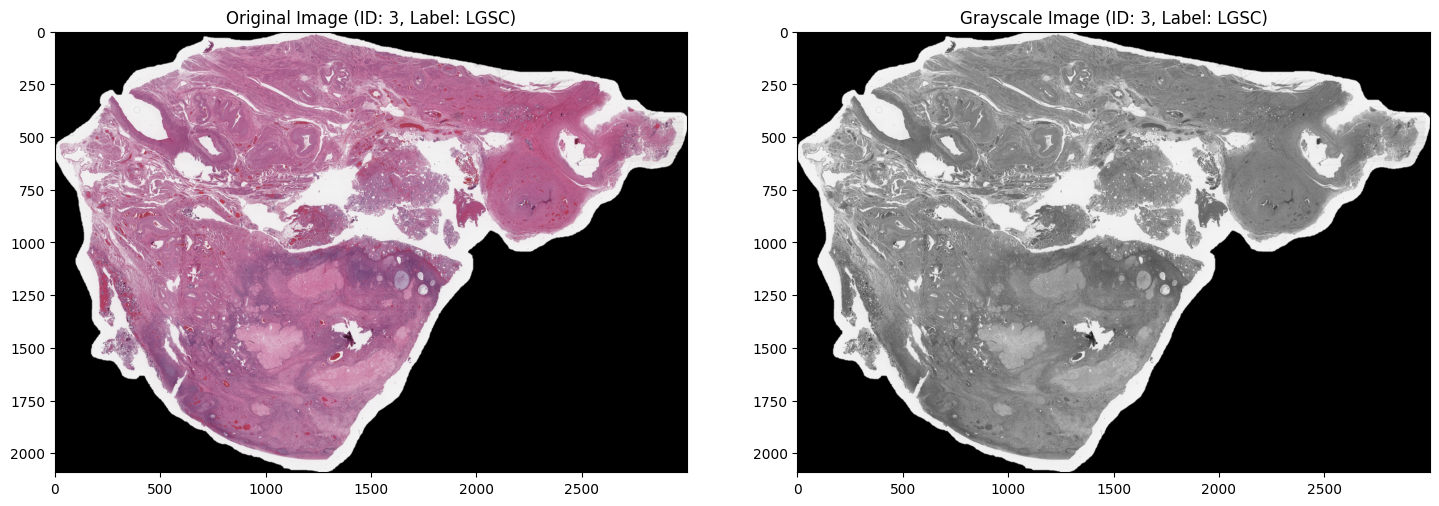

Flattened Array for Image ID 4 and Label MC:
[0 0 0 ... 0 0 0]



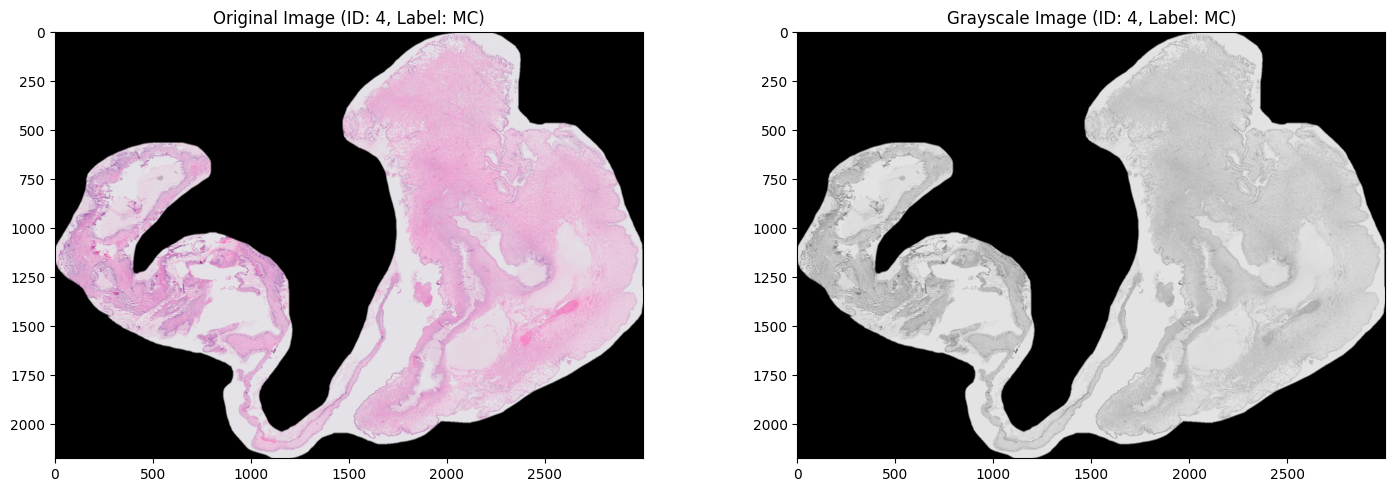

In [ ]:
def apply_grayscale_and_plot(image_id, label, image_path):
    image = Image.open(image_path)
    grayscale_image = image.convert('L')

    flattened_array = np.array(grayscale_image).flatten()
    print(f"Flattened Array for Image ID {image_id} and Label {label}:\n{flattened_array}\n")

    plt.figure(figsize=(15, 5))

    # Create a subplot for the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Original Image (ID: {image_id}, Label: {label})')

    # Create a subplot for the grayscale image
    plt.subplot(1, 2, 2)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title(f'Grayscale Image (ID: {image_id}, Label: {label})')

    plt.tight_layout()
    plt.show()

    return flattened_array

flattened_arrays = []

for idx, row in feature_extraction_df.iterrows():
    grayscale_features = apply_grayscale_and_plot(idx, row['label'], row['full_path'])
    flattened_arrays.append(grayscale_features)

**3: Conturing**

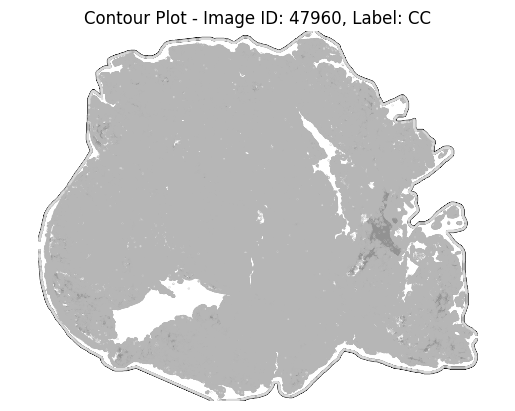

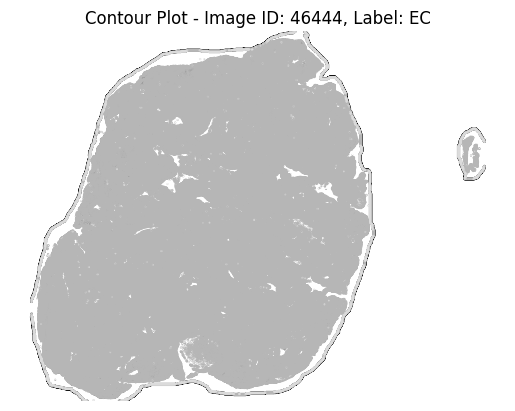

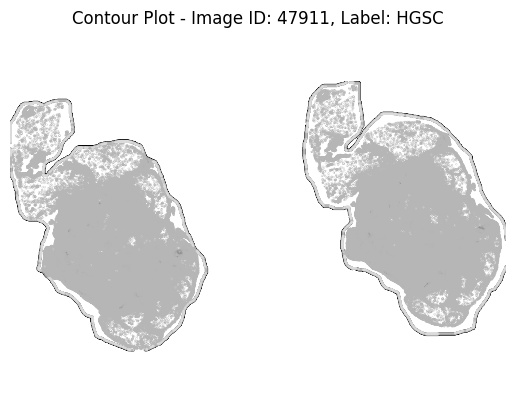

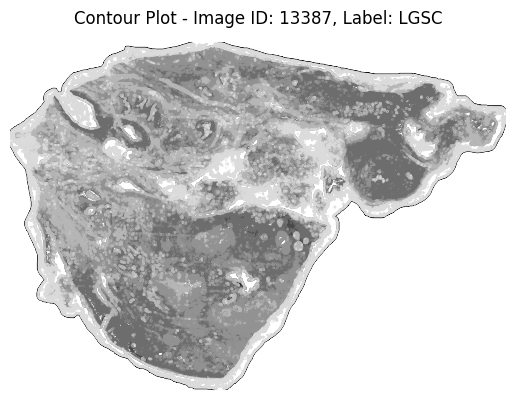

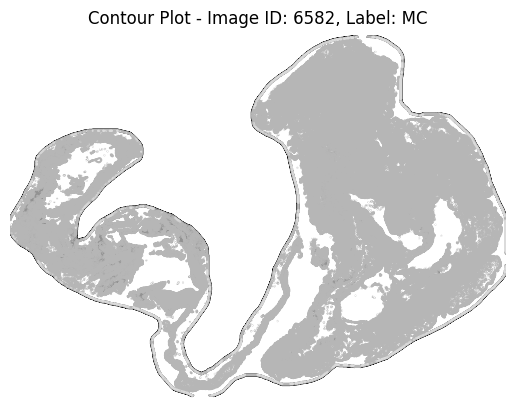

In [ ]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to apply contour and histogram plots to an image
def apply_contour_and_histogram(image_path, image_id, label):
    # Open an image
    image = Image.open(image_path)

    # Convert the image to grayscale
    im_array = np.array(image.convert('L'))

    # Create a new figure for contour plot
    plt.figure()
    plt.gray()
    plt.contour(im_array, origin='image')
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'Contour Plot - Image ID: {image_id}, Label: {label}')


# Iterate over rows in feature_extraction_df
for idx, row in feature_extraction_df.iterrows():
    apply_contour_and_histogram(row['full_path'], row['image_id'], row['label'])


**4: HOG (Histogram of Oriented Gradients)**

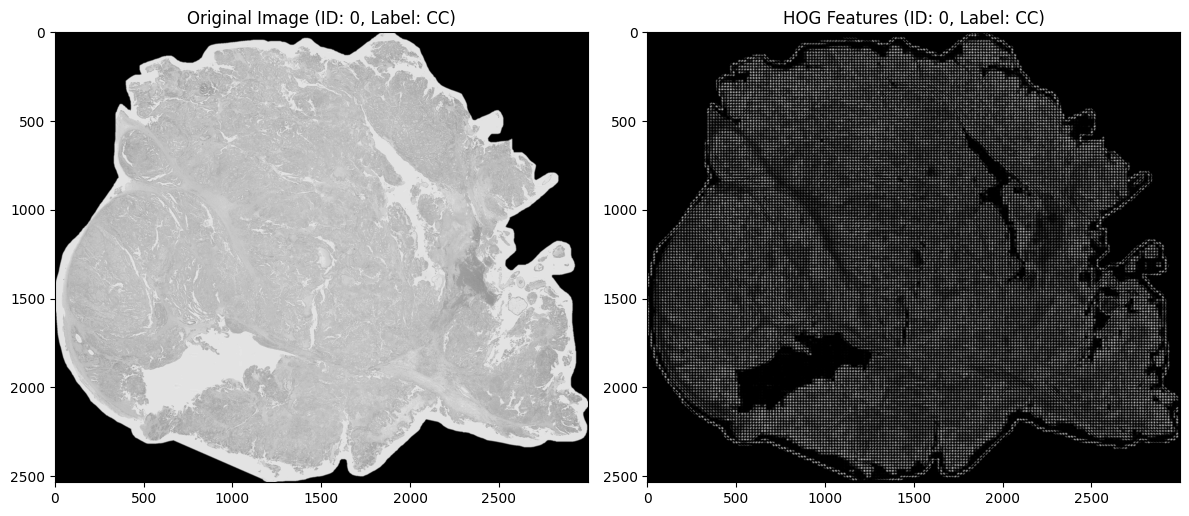

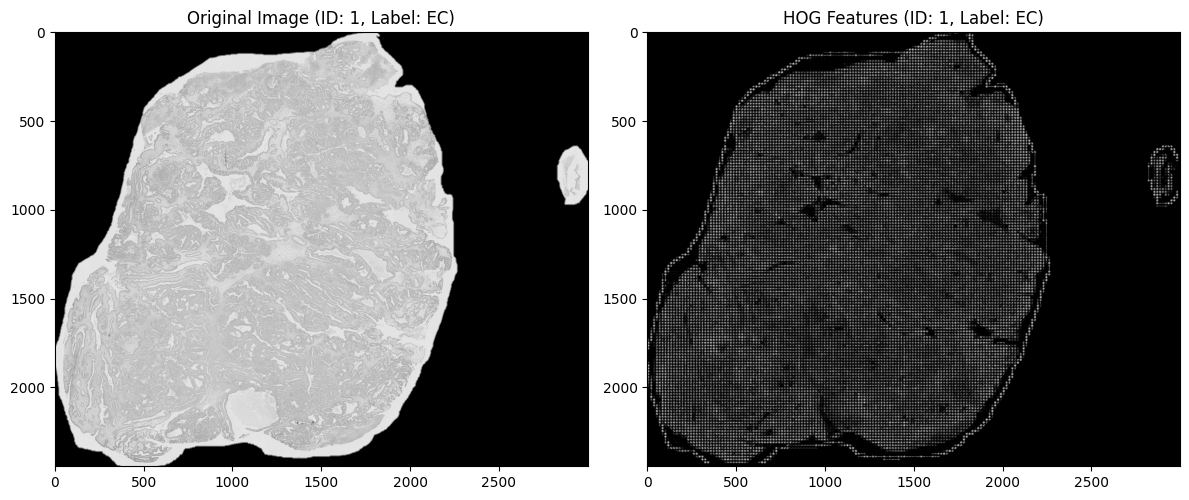

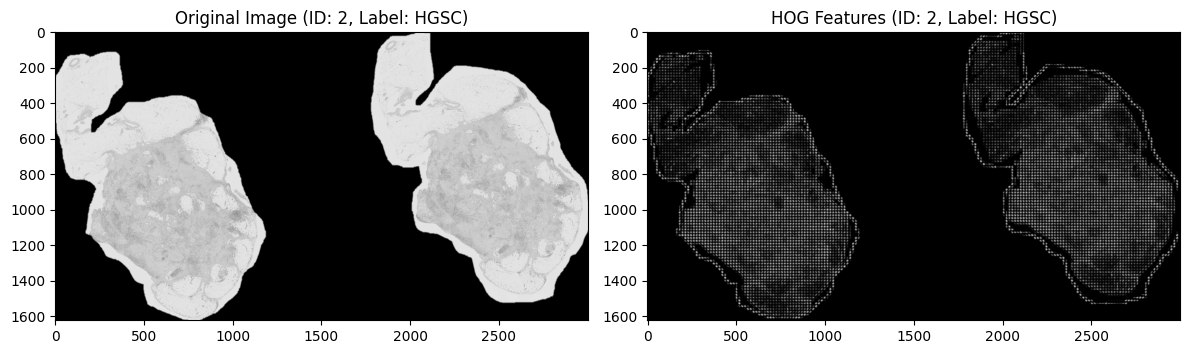

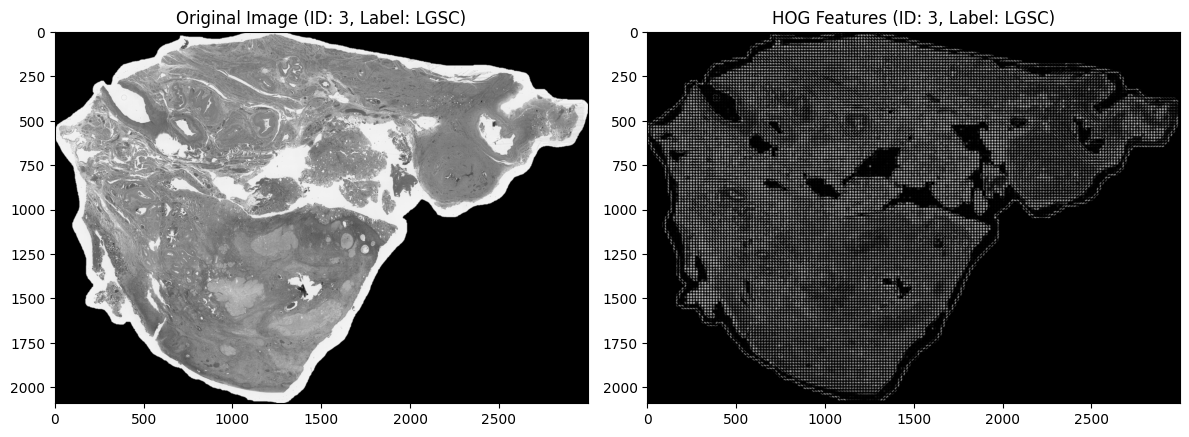

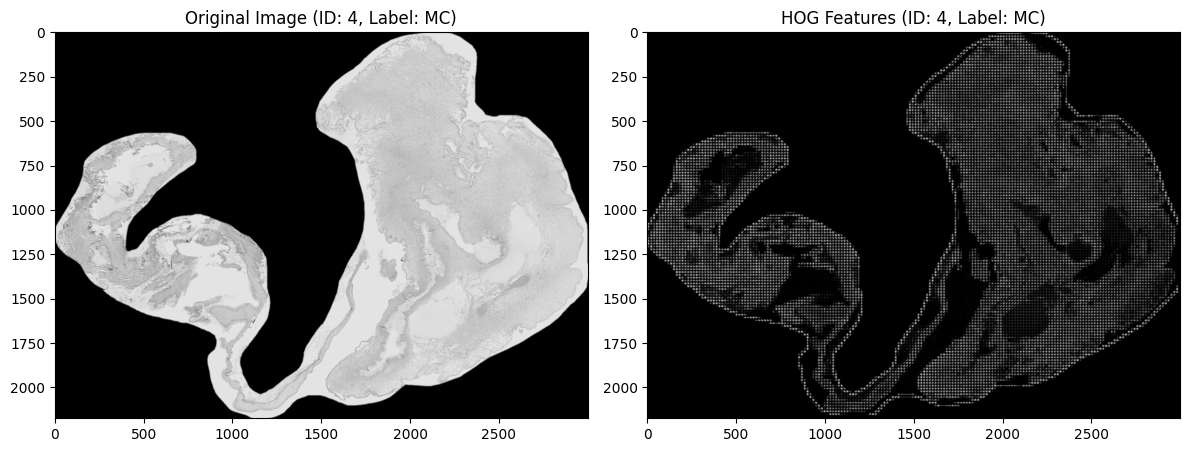

In [ ]:
from skimage.feature import hog
from skimage import exposure


def apply_hog_and_visualize(image_id, label, image_path):
    image = Image.open(image_path)

    # Convert the image to grayscale
    gray_image = image.convert('L')

    # Compute HOG features
    features, hog_image = hog(gray_image,
                              orientations=8,  # Number of orientation bins
                              pixels_per_cell=(16, 16),  # Size (in pixels) of a cell
                              cells_per_block=(1, 1),  # Number of cells in each block
                              block_norm='L2-Hys',  # Block normalization method
                              visualize=True)

    # Enhance the visualization using histogram equalization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 5))

    # Visualize the original and HOG images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(gray_image, cmap='gray')
    plt.title(f'Original Image (ID: {image_id}, Label: {label})')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title(f'HOG Features (ID: {image_id}, Label: {label})')

    plt.tight_layout()
    plt.show()

    return features

hog_features_list = []

for idx, row in feature_extraction_df.iterrows():
    hog_features = apply_hog_and_visualize(idx, row['label'], row['full_path'])